## 1. Import libraries

In [2]:
import numpy as np
# !pip install streamlit
import streamlit as st
import pandas as pd
pd.set_option("display.max_columns",None)


import sklearn
sklearn.set_config(transform_output= "pandas") 

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
	OneHotEncoder,
	OrdinalEncoder,
	StandardScaler,
	MinMaxScaler,
	PowerTransformer,
	FunctionTransformer,
    KBinsDiscretizer
)
from category_encoders import TargetEncoder


import seaborn as sns 
from feature_engine.outliers import Winsorizer
from feature_engine.datetime import DatetimeFeatures
from feature_engine.selection import SelectBySingleFeaturePerformance
from feature_engine.encoding import (
	RareLabelEncoder,
	MeanEncoder,
	CountFrequencyEncoder
)

import matplotlib.pyplot as plt

import os

import warnings
warnings.filterwarnings("ignore")

## 2. Read the dataset

In [6]:
def get_data(name):
    # Check if the dataset directory exists
    current_dir = os.getcwd()
    print("Current directory:", current_dir)

    if current_dir == "/Users/sudhirjoon/Library/Mobile Documents/com~apple~CloudDocs/Uni_Mannheim/Sem2/Machine Learning zoomcamp/MLZoomcamp":
        print("Dataset directory is correct.")
    else:
        # change directory
        current_dir = os.chdir('/Users/sudhirjoon/Library/Mobile Documents/com~apple~CloudDocs/Uni_Mannheim/Sem2/Machine Learning zoomcamp/MLZoomcamp')
        print("Current directory updated")

    # Check if the file exists
    data_path = "Midterm Project/German Real State Project/Data"
    file_name = f"{name}.csv"
    file_path = os.path.join(current_dir, data_path,file_name)
    return pd.read_csv(file_path)

In [7]:
train = get_data('cleaned_data')
train.shape

Current directory: /Users/sudhirjoon/Library/Mobile Documents/com~apple~CloudDocs/Uni_Mannheim/Sem2/Machine Learning zoomcamp/MLZoomcamp
Dataset directory is correct.


(200141, 30)

In [8]:
train.head()

,serviceCharge,picturecount,pricetrend,telekomUploadSpeed,totalRent,yearConstructedRange,baseRent,livingSpace,baseRentRange,geo_plz,noRooms,livingSpaceRange,stateName,heatingType,telekomTvOffer,newlyConst,balcony,firingTypes,hasKitchen,cellar,condition,interiorQual,petsAllowed,lift,typeOfFlat,garden,cityName,cityDistrict,yearConstructed_category,floor_category
0,245.00,6,4.62,10.0,840.0,2.0,595.0,86.00,4,44269,4,4,Nordrhein_Westfalen,central_heating,ONE_YEAR_FREE,False,False,oil,False,True,well_kept,normal,unknown,False,ground_floor,True,Dortmund,Schüren,1952-1973,floor_0_3
1,255.00,8,2.72,2.4,1300.0,9.0,965.0,83.80,6,1097,3,4,Sachsen,floor_heating,ONE_YEAR_FREE,True,True,district_heating,False,True,first_time_use,sophisticated,unknown,True,apartment,False,Dresden,Äußere_Neustadt_Antonstadt,1997-2030,floor_0_3
2,58.15,9,1.53,40.0,655.0,2.0,343.0,58.15,2,9599,3,2,Sachsen,district_heating,ONE_YEAR_FREE,False,True,district_heating,False,False,unknown,unknown,unknown,False,other,False,Mittelsachsen_Kreis,Freiberg,1952-1973,floor_0_3
3,138.00,19,2.46,40.0,903.0,1.0,765.0,84.97,5,28213,3,4,Bremen,self_contained_central_heating,unknown,False,True,gas,False,False,refurbished,unknown,unknown,False,apartment,False,Bremen,Neu_Schwachhausen,1881-1952,floor_0_3
4,142.00,5,4.48,2.4,655.0,5.0,315.2,53.43,2,24891,2,2,Schleswig_Holstein,gas_heating,unknown,False,True,gas,True,False,well_kept,unknown,no,False,apartment,False,Schleswig_Flensburg_Kreis,Struxdorf,1997-2030,floor_0_3


## 3. Transformation operations

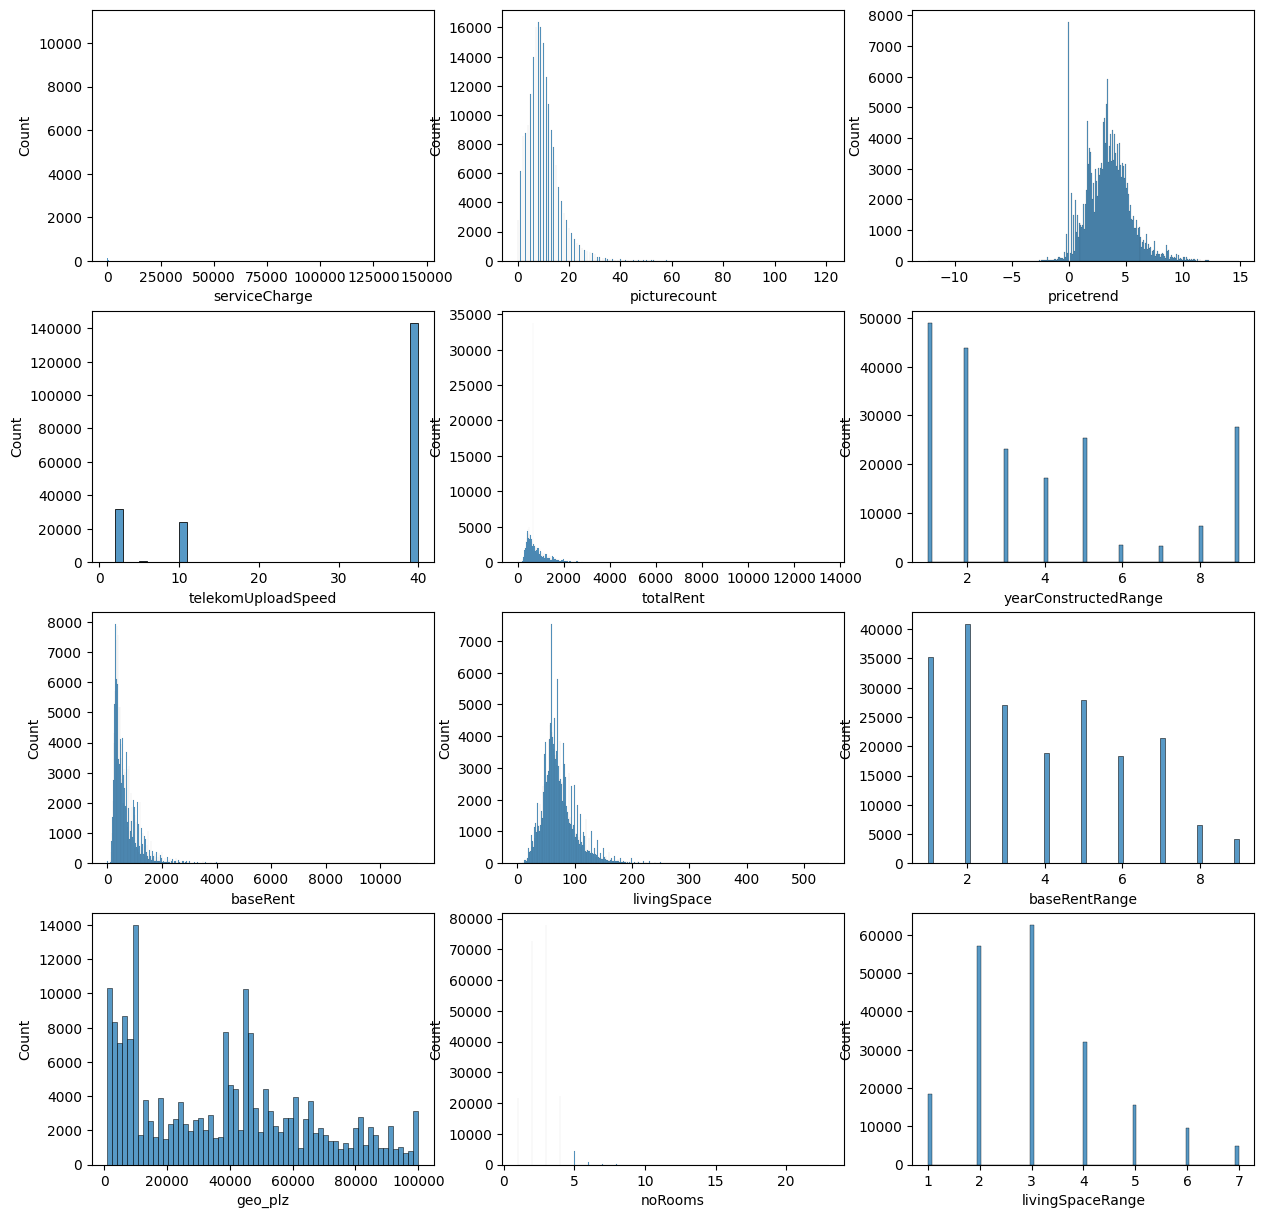

In [9]:
num_cols = train.select_dtypes(include='number').columns

n_cols = 3
n_rows = int(np.ceil(len(num_cols)/n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 15))

for i, col in enumerate(num_cols):
    sns.histplot(data = train, x = col, ax=axes[i//n_cols, i%n_cols])
    axes[i//n_cols, i%n_cols]


#### Creating new features

In [10]:
# creating new column total rent per square meters
train['totalRentPerSquareMeter']= train['totalRent']/train['livingSpace']

In [11]:
# make new column called address
train['address'] = train['geo_plz'].astype(str) + ' ' + train['cityName']  + ' ' + train['stateName'] 

In [12]:
# changing datatypes of the column
train['telekomUploadSpeed'] = train['telekomUploadSpeed'].astype('int').astype('object')
train['yearConstructedRange'] = train['yearConstructedRange'].astype('int').astype('object')
train['baseRentRange'] = train['baseRentRange'].astype('int').astype('object')
train['noRooms'] = train['noRooms'].astype('int').astype('object')
train['livingSpaceRange'] = train['livingSpaceRange'].astype('int').astype('object')
train['geo_plz'] = train['geo_plz'].astype('int').astype('object')
train['picturecount'] = train['picturecount'].astype('int').astype('object')

### Pairplot Numerical features

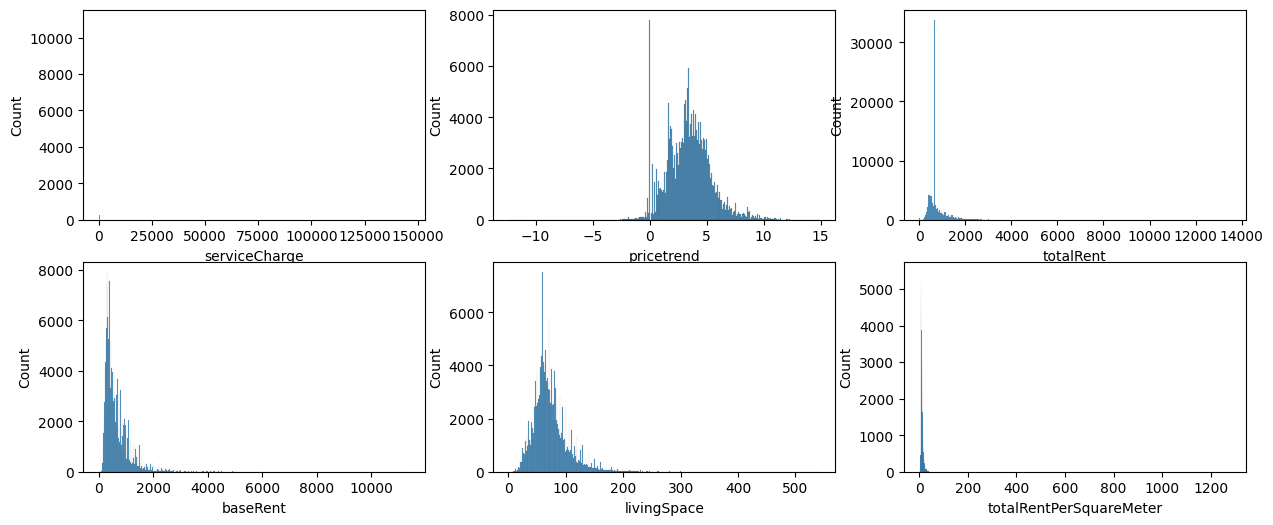

In [13]:
num_cols = train.select_dtypes(include='number').columns

n_cols = 3
n_rows = int(np.ceil(len(num_cols)/n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 6))

for i, col in enumerate(num_cols):
    sns.histplot(data = train, x = col, ax=axes[i//n_cols, i%n_cols])
    axes[i//n_cols, i%n_cols]

### Pairplot after log transformations

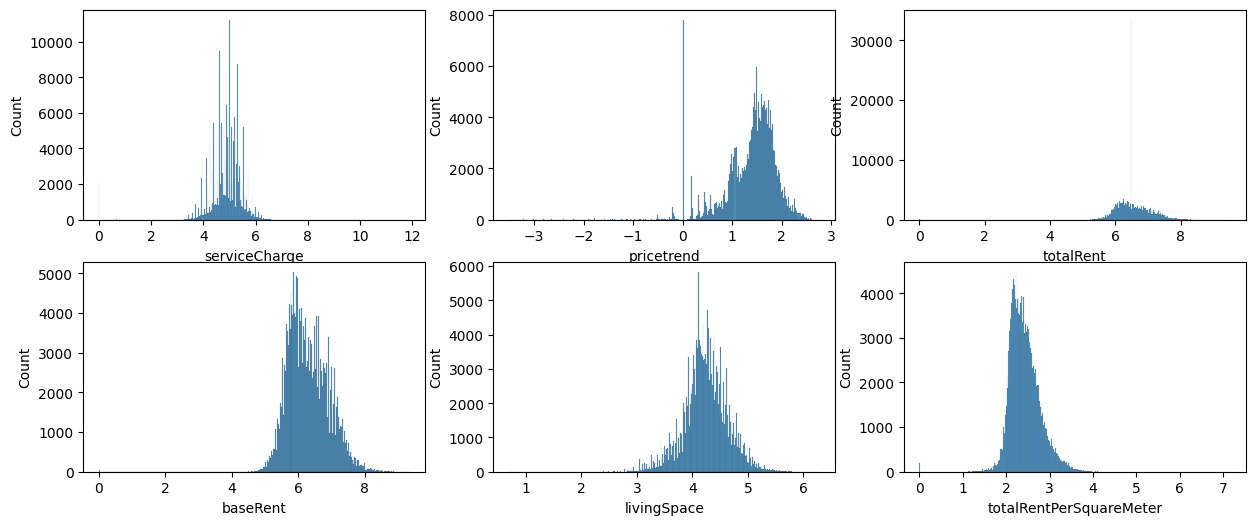

In [14]:
num_cols = train.select_dtypes(include='number').columns

n_cols = 3
n_rows = int(np.ceil(len(num_cols)/n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 6))

for i, col in enumerate(num_cols):
    sns.histplot(x = np.log1p(train[col]), ax=axes[i//n_cols, i%n_cols])
    axes[i//n_cols, i%n_cols]

### 3.1 Transformations on Numerical columns

In [15]:
X = train.drop(columns = ['totalRent'],axis= 1)
y = train['totalRent']

#### YeoJohnson and MinMax Scaling


In [40]:
num_cols = X.select_dtypes(include='number').columns

# Check for negative or zero values and handle them (for Box-Cox)
X[num_cols] = X[num_cols].applymap(lambda x: x + 1 if x <= 0 else x)


# Create transformers
yeo_johnson_transformer = PowerTransformer(method='yeo-johnson', standardize=True)
min_max_transformer = MinMaxScaler()
log_transformer = FunctionTransformer(np.log1p, validate=True)

# Define the numerical preprocessing pipeline
numerical_pipeline = Pipeline(steps=[
    ('yeo_johnson', PowerTransformer(method='yeo-johnson', standardize=True)),  # Step 1: Yeo-Johnson
    ('min_max_scaler', MinMaxScaler())  # Step 2: Min-Max Scaling
])

# Create a pipeline with all transformations
numerical_preprocessing_pipeline = ColumnTransformer(
    transformers =[
        ('num_pipeline', numerical_pipeline, num_cols)  # Apply to numerical columns
    ],
    remainder='drop'
)


preprocessed_num_data = numerical_preprocessing_pipeline.fit_transform(X,y)
display(pd.DataFrame(preprocessed_num_data).head())  # Inspect the output
print(pd.DataFrame(preprocessed_num_data).shape)

,num_pipeline__serviceCharge,num_pipeline__pricetrend,num_pipeline__baseRent,num_pipeline__livingSpace,num_pipeline__totalRentPerSquareMeter
0,0.094884,0.861874,0.736052,0.607771,0.594296
1,0.096432,0.826455,0.783812,0.602796,0.660976
2,0.051460,0.800218,0.679303,0.534208,0.615575
3,0.074891,0.821065,0.761110,0.605456,0.606967
4,0.075794,0.859457,0.670370,0.518733,0.627908


(200141, 5)


In [41]:
numerical_preprocessing_pipeline

ColumnTransformer(transformers=[('num_pipeline',
                                 Pipeline(steps=[('yeo_johnson',
                                                  PowerTransformer()),
                                                 ('min_max_scaler',
                                                  MinMaxScaler())]),
                                 Index(['serviceCharge', 'pricetrend', 'baseRent', 'livingSpace',
       'totalRentPerSquareMeter'],
      dtype='object'))])

In [42]:
print(numerical_preprocessing_pipeline)

ColumnTransformer(transformers=[('num_pipeline',
                                 Pipeline(steps=[('yeo_johnson',
                                                  PowerTransformer()),
                                                 ('min_max_scaler',
                                                  MinMaxScaler())]),
                                 Index(['serviceCharge', 'pricetrend', 'baseRent', 'livingSpace',
       'totalRentPerSquareMeter'],
      dtype='object'))])


### 3.2 Feature Engineering Categorical Columns

In [43]:
(
    train
    .select_dtypes(include=['object','bool'])
    .head()
)

,picturecount,telekomUploadSpeed,yearConstructedRange,baseRentRange,geo_plz,noRooms,livingSpaceRange,stateName,heatingType,telekomTvOffer,newlyConst,balcony,firingTypes,hasKitchen,cellar,condition,interiorQual,petsAllowed,lift,typeOfFlat,garden,cityName,cityDistrict,yearConstructed_category,floor_category,address
0,6,10,2,4,44269,4,4,Nordrhein_Westfalen,central_heating,ONE_YEAR_FREE,False,False,oil,False,True,well_kept,normal,unknown,False,ground_floor,True,Dortmund,Schüren,1952-1973,floor_0_3,44269 Dortmund Nordrhein_Westfalen
1,8,2,9,6,1097,3,4,Sachsen,floor_heating,ONE_YEAR_FREE,True,True,district_heating,False,True,first_time_use,sophisticated,unknown,True,apartment,False,Dresden,Äußere_Neustadt_Antonstadt,1997-2030,floor_0_3,1097 Dresden Sachsen
2,9,40,2,2,9599,3,2,Sachsen,district_heating,ONE_YEAR_FREE,False,True,district_heating,False,False,unknown,unknown,unknown,False,other,False,Mittelsachsen_Kreis,Freiberg,1952-1973,floor_0_3,9599 Mittelsachsen_Kreis Sachsen
3,19,40,1,5,28213,3,4,Bremen,self_contained_central_heating,unknown,False,True,gas,False,False,refurbished,unknown,unknown,False,apartment,False,Bremen,Neu_Schwachhausen,1881-1952,floor_0_3,28213 Bremen Bremen
4,5,2,5,2,24891,2,2,Schleswig_Holstein,gas_heating,unknown,False,True,gas,True,False,well_kept,unknown,no,False,apartment,False,Schleswig_Flensburg_Kreis,Struxdorf,1997-2030,floor_0_3,24891 Schleswig_Flensburg_Kreis Schleswig_Hols...


In [44]:
print(train.select_dtypes(include=['object','bool']).shape)

(200141, 26)


In [45]:
(
    train
    .select_dtypes(include=['object','bool'])
    .nunique()
    .sort_values(ascending=False)
)

cityDistrict                7967
address                     7192
geo_plz                     7049
cityName                     419
firingTypes                  125
picturecount                  91
stateName                     16
noRooms                       16
heatingType                   13
condition                     11
typeOfFlat                    10
yearConstructedRange           9
baseRentRange                  9
livingSpaceRange               7
telekomUploadSpeed             6
floor_category                 5
interiorQual                   5
petsAllowed                    4
yearConstructed_category       4
telekomTvOffer                 3
lift                           2
cellar                         2
garden                         2
balcony                        2
newlyConst                     2
hasKitchen                     2
dtype: int64

### Encoding Strategies
- **Binary**: Label Encoding or One-Hot Encoding
- **Low Cardinality**: One-Hot Encoding
- **Medium Cardinality**: One-Hot Encoding or Target Encoding
- **High Cardinality**: Target Encoding, Frequency Encoding, or Embedding

In [46]:

# Define feature groups
binary_features = ['newlyConst', 'balcony', 'hasKitchen', 'cellar', 'lift', 'garden']
low_card_features = ['stateName', 'telekomTvOffer', 'petsAllowed', 'typeOfFlat']
med_card_features = ['heatingType', 'condition', 'interiorQual', 'address']
high_card_features = ['geo_plz', 'cityName', 'cityDistrict', 'firingTypes', 'address']
numeric_binned = ['picturecount', 'noRooms']
ordinal_features = ['yearConstructedRange', 'baseRentRange', 'livingSpaceRange', 
                    'yearConstructed_category', 'floor_category']

In [47]:
# create preprocessing steps
binary_transformer = 'passthrough'
low_card_transformer = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
med_card_transformer = TargetEncoder()
high_card_transformer = TargetEncoder()
numeric_binned_transformer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
ordinal_transformer = OrdinalEncoder()

In [48]:
# creating categorical preprocessing pipeline
categorical_preprocessing_pipeline = ColumnTransformer(
    transformers=[
        ('binary', 'passthrough', binary_features),
        ('low_card', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), low_card_features),
        ('med_card', TargetEncoder(), med_card_features),
        ('high_card', TargetEncoder(), high_card_features),
        ('numeric_binned', KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform'), numeric_binned),
        ('ordinal', OrdinalEncoder(), ordinal_features)
    ],
    remainder='drop'
)


In [49]:
print(categorical_preprocessing_pipeline)

ColumnTransformer(transformers=[('binary', 'passthrough',
                                 ['newlyConst', 'balcony', 'hasKitchen',
                                  'cellar', 'lift', 'garden']),
                                ('low_card',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['stateName', 'telekomTvOffer', 'petsAllowed',
                                  'typeOfFlat']),
                                ('med_card', TargetEncoder(),
                                 ['heatingType', 'condition', 'interiorQual',
                                  'address']),
                                ('high_card', TargetEncoder(),
                                 ['geo_plz', 'cityName', 'cityDistrict',
                                  'firingTypes', 'address']),
                                ('numeric_binned',
                                 KBinsDiscretizer(enc

In [50]:
preprocessed_cat_data = categorical_preprocessing_pipeline.fit_transform(X,y)
preprocessed_cat_df = pd.DataFrame(preprocessed_cat_data)
display(preprocessed_cat_df.head())
print(preprocessed_cat_df.shape)

,binary__newlyConst,binary__balcony,binary__hasKitchen,binary__cellar,binary__lift,binary__garden,low_card__stateName_Baden_Württemberg,low_card__stateName_Bayern,low_card__stateName_Berlin,low_card__stateName_Brandenburg,low_card__stateName_Bremen,low_card__stateName_Hamburg,low_card__stateName_Hessen,low_card__stateName_Mecklenburg_Vorpommern,low_card__stateName_Niedersachsen,low_card__stateName_Nordrhein_Westfalen,low_card__stateName_Rheinland_Pfalz,low_card__stateName_Saarland,low_card__stateName_Sachsen,low_card__stateName_Sachsen_Anhalt,low_card__stateName_Schleswig_Holstein,low_card__stateName_Thüringen,low_card__telekomTvOffer_ONE_YEAR_FREE,low_card__telekomTvOffer_ON_DEMAND,low_card__telekomTvOffer_unknown,low_card__petsAllowed_negotiable,low_card__petsAllowed_no,low_card__petsAllowed_unknown,low_card__petsAllowed_yes,low_card__typeOfFlat_apartment,low_card__typeOfFlat_ground_floor,low_card__typeOfFlat_half_basement,low_card__typeOfFlat_loft,low_card__typeOfFlat_maisonette,low_card__typeOfFlat_other,low_card__typeOfFlat_penthouse,low_card__typeOfFlat_raised_ground_floor,low_card__typeOfFlat_roof_storey,low_card__typeOfFlat_terraced_flat,med_card__heatingType,med_card__condition,med_card__interiorQual,med_card__address,high_card__geo_plz,high_card__cityName,high_card__cityDistrict,high_card__firingTypes,high_card__address,numeric_binned__picturecount,numeric_binned__noRooms,ordinal__yearConstructedRange,ordinal__baseRentRange,ordinal__livingSpaceRange,ordinal__yearConstructed_category,ordinal__floor_category
0,False,False,False,True,False,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,747.188398,702.826563,619.734247,951.958199,951.958199,732.622202,1047.432327,812.379328,951.958199,0.0,0.0,1.0,3.0,3.0,1.0,0.0
1,True,True,False,True,True,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1207.133159,1208.945307,1048.553574,802.044484,800.607042,740.351808,828.959870,805.145414,802.044484,0.0,0.0,8.0,5.0,3.0,3.0,0.0
2,False,True,False,False,False,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,768.486728,708.999159,718.760225,584.895738,584.691598,489.436220,587.017336,805.145414,584.895738,0.0,0.0,1.0,1.0,1.0,1.0,0.0
3,False,True,False,False,False,False,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,721.002345,635.648127,718.760225,981.975714,981.975714,851.943960,994.498427,782.735822,981.975714,0.0,0.0,0.0,4.0,3.0,0.0,0.0
4,False,True,True,False,False,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,807.522017,702.826563,718.760225,792.433139,792.433139,744.631348,792.433139,782.735822,792.433139,0.0,0.0,4.0,1.0,1.0,3.0,0.0


(200141, 55)


In [51]:
(
    preprocessed_cat_df
    .nunique()
    .sort_values(ascending=False)
)

high_card__cityDistrict                       6165
med_card__address                             5705
high_card__address                            5705
high_card__geo_plz                            5662
high_card__cityName                            419
high_card__firingTypes                         110
med_card__heatingType                           13
med_card__condition                             11
ordinal__baseRentRange                           9
ordinal__yearConstructedRange                    9
ordinal__livingSpaceRange                        7
med_card__interiorQual                           5
ordinal__floor_category                          5
numeric_binned__picturecount                     5
numeric_binned__noRooms                          5
ordinal__yearConstructed_category                4
low_card__petsAllowed_yes                        2
low_card__typeOfFlat_terraced_flat               2
low_card__typeOfFlat_roof_storey                 2
low_card__typeOfFlat_raised_gro

## 4. Combining both pipeline

In [52]:
preprocessing_pipeline = ColumnTransformer(
    transformers=[
        ('numerical', numerical_preprocessing_pipeline, list(X.select_dtypes(include=['number']).columns)),
        ('categorical', categorical_preprocessing_pipeline,list(X.select_dtypes(include=['object', 'bool']).columns) )
    ],
    remainder='drop'
)

In [53]:
print(preprocessing_pipeline)

ColumnTransformer(transformers=[('numerical',
                                 ColumnTransformer(transformers=[('num_pipeline',
                                                                  Pipeline(steps=[('yeo_johnson',
                                                                                   PowerTransformer()),
                                                                                  ('min_max_scaler',
                                                                                   MinMaxScaler())]),
                                                                  Index(['serviceCharge', 'pricetrend', 'baseRent', 'livingSpace',
       'totalRentPerSquareMeter'],
      dtype='object'))]),
                                 ['serviceCharge', 'pricetrend', 'baseRent',
                                  'livingSpace', 'totalRe...
                                 ['picturecount', 'telekomUploadSpeed',
                                  'yearConstructedRange', 'baseRe

In [54]:

# Apply transformations
preprocessed_data = preprocessing_pipeline.fit_transform(X,y)

# Get feature names
# This part might need adjustment based on your specific dataset
feature_names = list(preprocessing_pipeline.get_feature_names_out())
print(len(feature_names))


60


In [55]:
# Create DataFrame
preprocessed_data_df = pd.DataFrame(
    preprocessed_data, 
    columns=feature_names, 
    index=X.index
)

# Display the first few rows
display(preprocessed_data_df.head())
print(preprocessed_data_df.shape)

,numerical__num_pipeline__serviceCharge,numerical__num_pipeline__pricetrend,numerical__num_pipeline__baseRent,numerical__num_pipeline__livingSpace,numerical__num_pipeline__totalRentPerSquareMeter,categorical__binary__newlyConst,categorical__binary__balcony,categorical__binary__hasKitchen,categorical__binary__cellar,categorical__binary__lift,categorical__binary__garden,categorical__low_card__stateName_Baden_Württemberg,categorical__low_card__stateName_Bayern,categorical__low_card__stateName_Berlin,categorical__low_card__stateName_Brandenburg,categorical__low_card__stateName_Bremen,categorical__low_card__stateName_Hamburg,categorical__low_card__stateName_Hessen,categorical__low_card__stateName_Mecklenburg_Vorpommern,categorical__low_card__stateName_Niedersachsen,categorical__low_card__stateName_Nordrhein_Westfalen,categorical__low_card__stateName_Rheinland_Pfalz,categorical__low_card__stateName_Saarland,categorical__low_card__stateName_Sachsen,categorical__low_card__stateName_Sachsen_Anhalt,categorical__low_card__stateName_Schleswig_Holstein,categorical__low_card__stateName_Thüringen,categorical__low_card__telekomTvOffer_ONE_YEAR_FREE,categorical__low_card__telekomTvOffer_ON_DEMAND,categorical__low_card__telekomTvOffer_unknown,categorical__low_card__petsAllowed_negotiable,categorical__low_card__petsAllowed_no,categorical__low_card__petsAllowed_unknown,categorical__low_card__petsAllowed_yes,categorical__low_card__typeOfFlat_apartment,categorical__low_card__typeOfFlat_ground_floor,categorical__low_card__typeOfFlat_half_basement,categorical__low_card__typeOfFlat_loft,categorical__low_card__typeOfFlat_maisonette,categorical__low_card__typeOfFlat_other,categorical__low_card__typeOfFlat_penthouse,categorical__low_card__typeOfFlat_raised_ground_floor,categorical__low_card__typeOfFlat_roof_storey,categorical__low_card__typeOfFlat_terraced_flat,categorical__med_card__heatingType,categorical__med_card__condition,categorical__med_card__interiorQual,categorical__med_card__address,categorical__high_card__geo_plz,categorical__high_card__cityName,categorical__high_card__cityDistrict,categorical__high_card__firingTypes,categorical__high_card__address,categorical__numeric_binned__picturecount,categorical__numeric_binned__noRooms,categorical__ordinal__yearConstructedRange,categorical__ordinal__baseRentRange,categorical__ordinal__livingSpaceRange,categorical__ordinal__yearConstructed_category,categorical__ordinal__floor_category
0,0.094884,0.861874,0.736052,0.607771,0.594296,False,False,False,True,False,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,747.188398,702.826563,619.734247,951.958199,951.958199,732.622202,1047.432327,812.379328,951.958199,0.0,0.0,1.0,3.0,3.0,1.0,0.0
1,0.096432,0.826455,0.783812,0.602796,0.660976,True,True,False,True,True,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1207.133159,1208.945307,1048.553574,802.044484,800.607042,740.351808,828.959870,805.145414,802.044484,0.0,0.0,8.0,5.0,3.0,3.0,0.0
2,0.051460,0.800218,0.679303,0.534208,0.615575,False,True,False,False,False,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,768.486728,708.999159,718.760225,584.895738,584.691598,489.436220,587.017336,805.145414,584.895738,0.0,0.0,1.0,1.0,1.0,1.0,0.0
3,0.074891,0.821065,0.761110,0.605456,0.606967,False,True,False,False,False,False,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,721.002345,635.648127,718.760225,981.975714,981.975714,851.943960,994.498427,782.735822,981.975714,0.0,0.0,0.0,4.0,3.0,0.0,0.0
4,0.075794,0.859457,0.670370,0.518733,0.627908,False,True,True,False,False,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0

(200141, 60)


In [56]:
(
    preprocessed_data_df
    .select_dtypes(include=['object','bool'])
    .nunique()
    .sort_values(ascending=False)
)

categorical__binary__newlyConst    2
categorical__binary__balcony       2
categorical__binary__hasKitchen    2
categorical__binary__cellar        2
categorical__binary__lift          2
categorical__binary__garden        2
dtype: int64

In [57]:
preprocessed_data_df = pd.concat([preprocessed_data_df,train['totalRent']], axis=1)
print(preprocessed_data_df.shape)

(200141, 61)


In [58]:
def export_dataframe(dataframe, file_name):
    # Define the path where the CSV will be saved
    path = '/Users/sudhirjoon/Library/Mobile Documents/com~apple~CloudDocs/Uni_Mannheim/Sem2/Machine Learning zoomcamp/MLZoomcamp/Midterm Project/German Real State Project/Data'
    
    # Ensure the directory exists
    os.makedirs(path, exist_ok=True)
    
    # Create the full file path
    file_path = os.path.join(path, file_name)
    
    # Export the dataframe to CSV
    dataframe.to_csv(file_path, index=False)
    
    print(f"DataFrame exported to: {file_path}")

In [59]:
export_dataframe(preprocessed_data_df, 'preprocessed_data.csv')

DataFrame exported to: /Users/sudhirjoon/Library/Mobile Documents/com~apple~CloudDocs/Uni_Mannheim/Sem2/Machine Learning zoomcamp/MLZoomcamp/Midterm Project/German Real State Project/Data/preprocessed_data.csv
